In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from transformer_pipeline import drop_rows, get_features_transformer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, HDBSCAN, OPTICS, SpectralClustering  #it is avaliable since 1.3 version
from sklearn.mixture import GaussianMixture
from scipy.stats import uniform, randint,poisson
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from metrics import *
from custom_preprocessors import IdentityTransformer
from sklearn.model_selection import train_test_split
from dimensionality_reduction_and_explanation_tools import *
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("data/movie_statistic_dataset.csv")
df, val = train_test_split(data, test_size=0.2, random_state=14)
df = drop_rows(df)

In [5]:
transformer = make_pipeline(get_features_transformer(PowerTransformer(method="box-cox"),
                                          PowerTransformer(method="box-cox"),
                                          StandardScaler(),
                                          StandardScaler()), MinMaxScaler())
X = transformer.fit_transform(df)

In [42]:
estimators = [
    ("AgglomerativeClustering", AgglomerativeClustering(**{'distance_threshold': 6.428281262810862, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': None})), 
    ("DBSCAN", DBSCAN(min_samples= 19, eps=0.05, algorithm = 'auto', metric = 'jaccard')),
    ("HDBSCAN1", HDBSCAN(min_samples = 4, min_cluster_size= 10, metric='jaccard')),
    ("HDBSCAN2", HDBSCAN(min_samples = 4, min_cluster_size= 19, metric='jaccard')),
    ("HDBSCAN3", HDBSCAN(min_samples = 6, min_cluster_size= 10, metric='jaccard')),
    ("OPTICS", OPTICS(**{'algorithm': 'auto', 'cluster_method': 'xi', 'eps': None, 'leaf_size': 23, 'max_eps': 50, 'metric': 'jaccard', 'min_cluster_size': None, 'min_samples': 3, 'p': 2.0, 'xi': 0.1118693145882581})),
    ("SpectralClustering", SpectralClustering(**{'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'degree': 3.0, 'eigen_solver': 'lobpcg', 'eigen_tol': 'auto', 'gamma': 1.0, 'n_clusters': 38, 'n_components': 14, 'n_init': 10, 'n_neighbors': 10, 'random_state': 420})),
    ("GaussianMixture", GaussianMixture(**{'covariance_type': 'diag', 'init_params': 'kmeans', 'max_iter': 100, 'n_components': 22, 'n_init': 3, 'random_state': 420}))
]

In [43]:
resultsT = pd.DataFrame(columns=["estimator", "stat", "score"])

e_names = []
scores_fun = [davies_bouldin, silhouette, min_distance_between_clusters]
scores = [[] for i in range(2)]

for name,es in estimators:
    for i, fun in enumerate(scores_fun):
        e_names.append(name)
        scores[0].append(fun.__name__)
        scores[1].append(fun(es, X))

resultsT["estimator"] = e_names
resultsT["stat"] = scores[0]
resultsT["score"] = scores[1]

resultsT.head(10)

,estimator,stat,score
0,AgglomerativeClustering,davies_bouldin,0.708933
1,AgglomerativeClustering,silhouette,0.268929
2,AgglomerativeClustering,min_distance_between_clusters,1.001601
3,DBSCAN,davies_bouldin,0.712006
4,DBSCAN,silhouette,0.075072
5,DBSCAN,min_distance_between_clusters,0.137805
6,HDBSCAN1,davies_bouldin,0.703464
7,HDBSCAN1,silhouette,0.224581
8,HDBSCAN1,min_distance_between_clusters,0.132091
9,HDBSCAN2,davies_bouldin,0.667695


In [46]:
resultsT.loc[resultsT.stat == 'silhouette']

,estimator,stat,score
1,AgglomerativeClustering,silhouette,0.268929
4,DBSCAN,silhouette,0.075072
7,HDBSCAN1,silhouette,0.224581
10,HDBSCAN2,silhouette,0.126954
13,HDBSCAN3,silhouette,0.227840
16,OPTICS,silhouette,0.313957
19,SpectralClustering,silhouette,0.182885
22,GaussianMixture,silhouette,0.211299


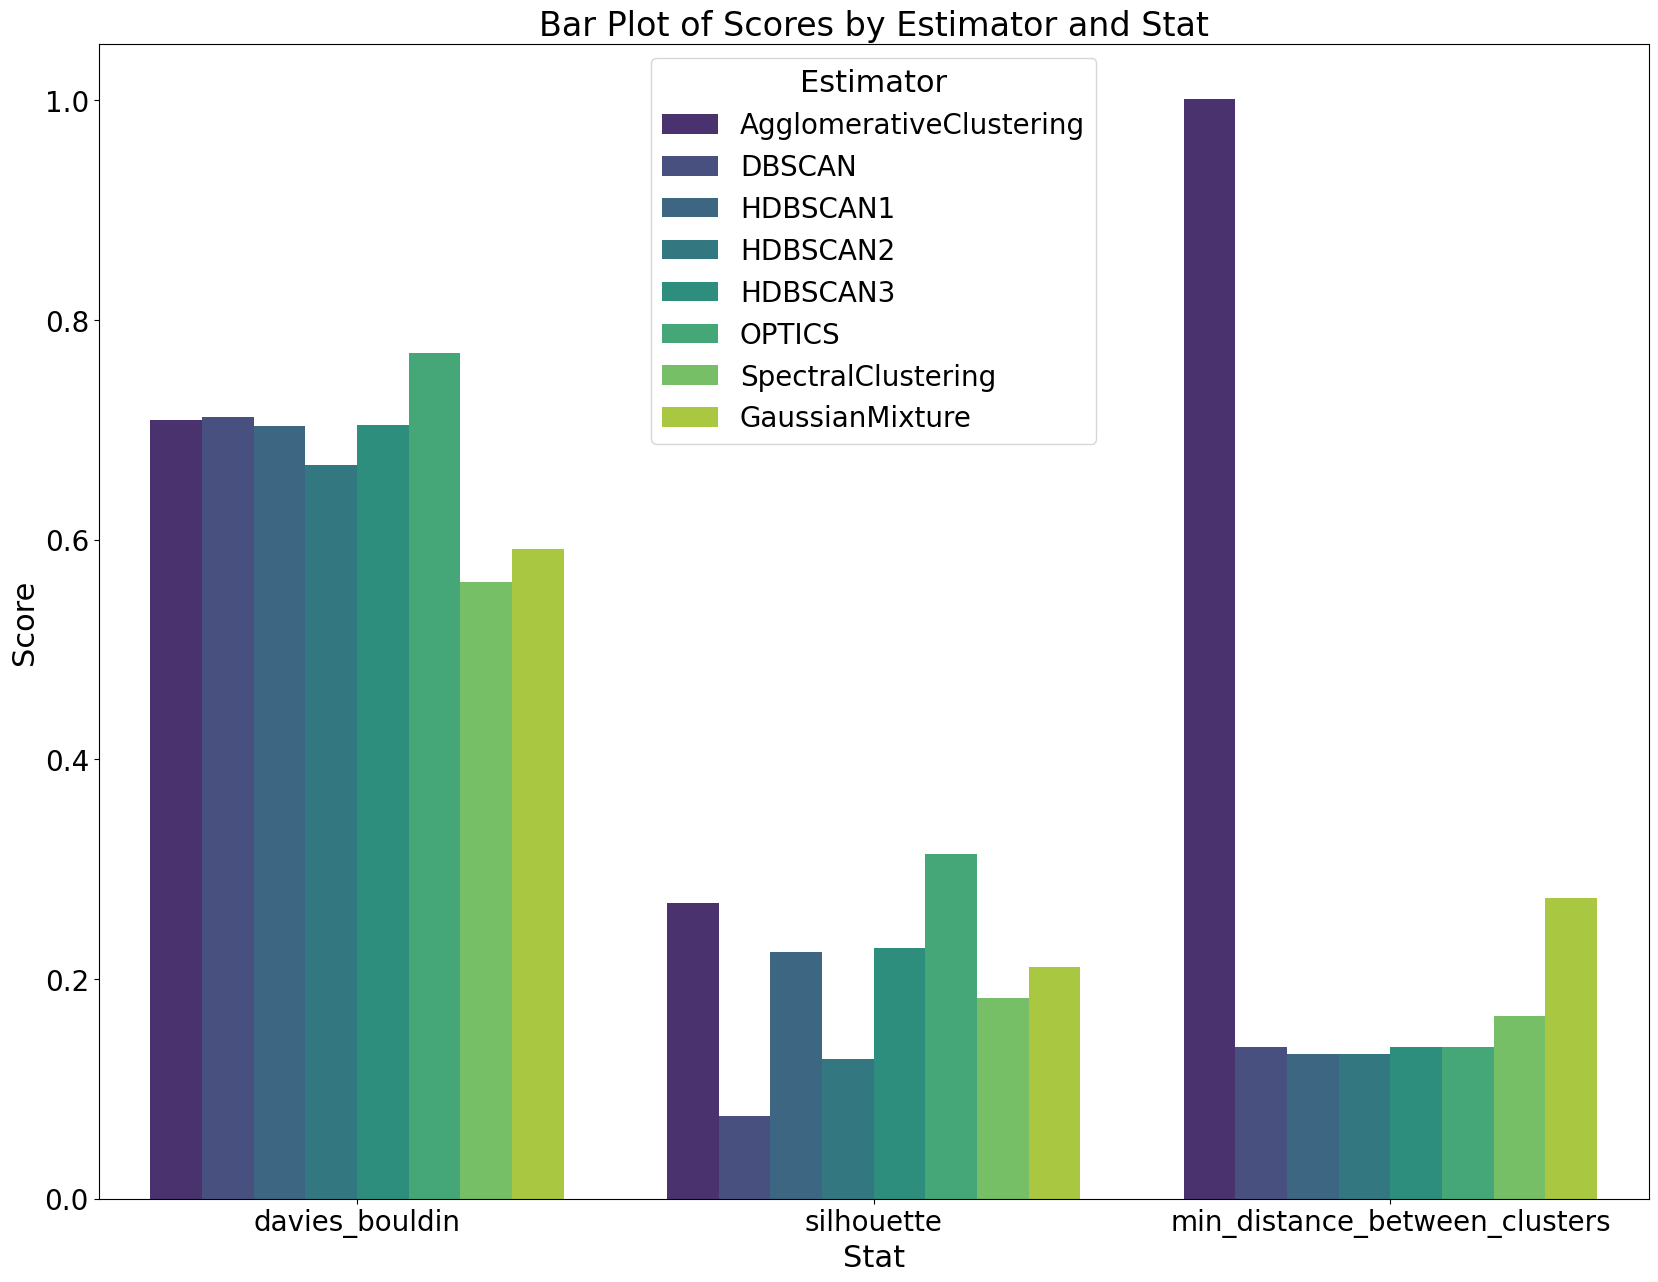

In [44]:
plt.figure(figsize=(20,15))
sns.barplot(resultsT,x = "stat", y = "score", hue="estimator", palette="viridis")

font_size = 20
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xlabel('Stat', fontsize=font_size+2)
plt.ylabel('Score', fontsize=font_size+2)
plt.title('Bar Plot of Scores by Estimator and Stat', fontsize=font_size+4)
plt.legend(title='Estimator', title_fontsize=font_size+2, fontsize=font_size)

plt.show()

[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values


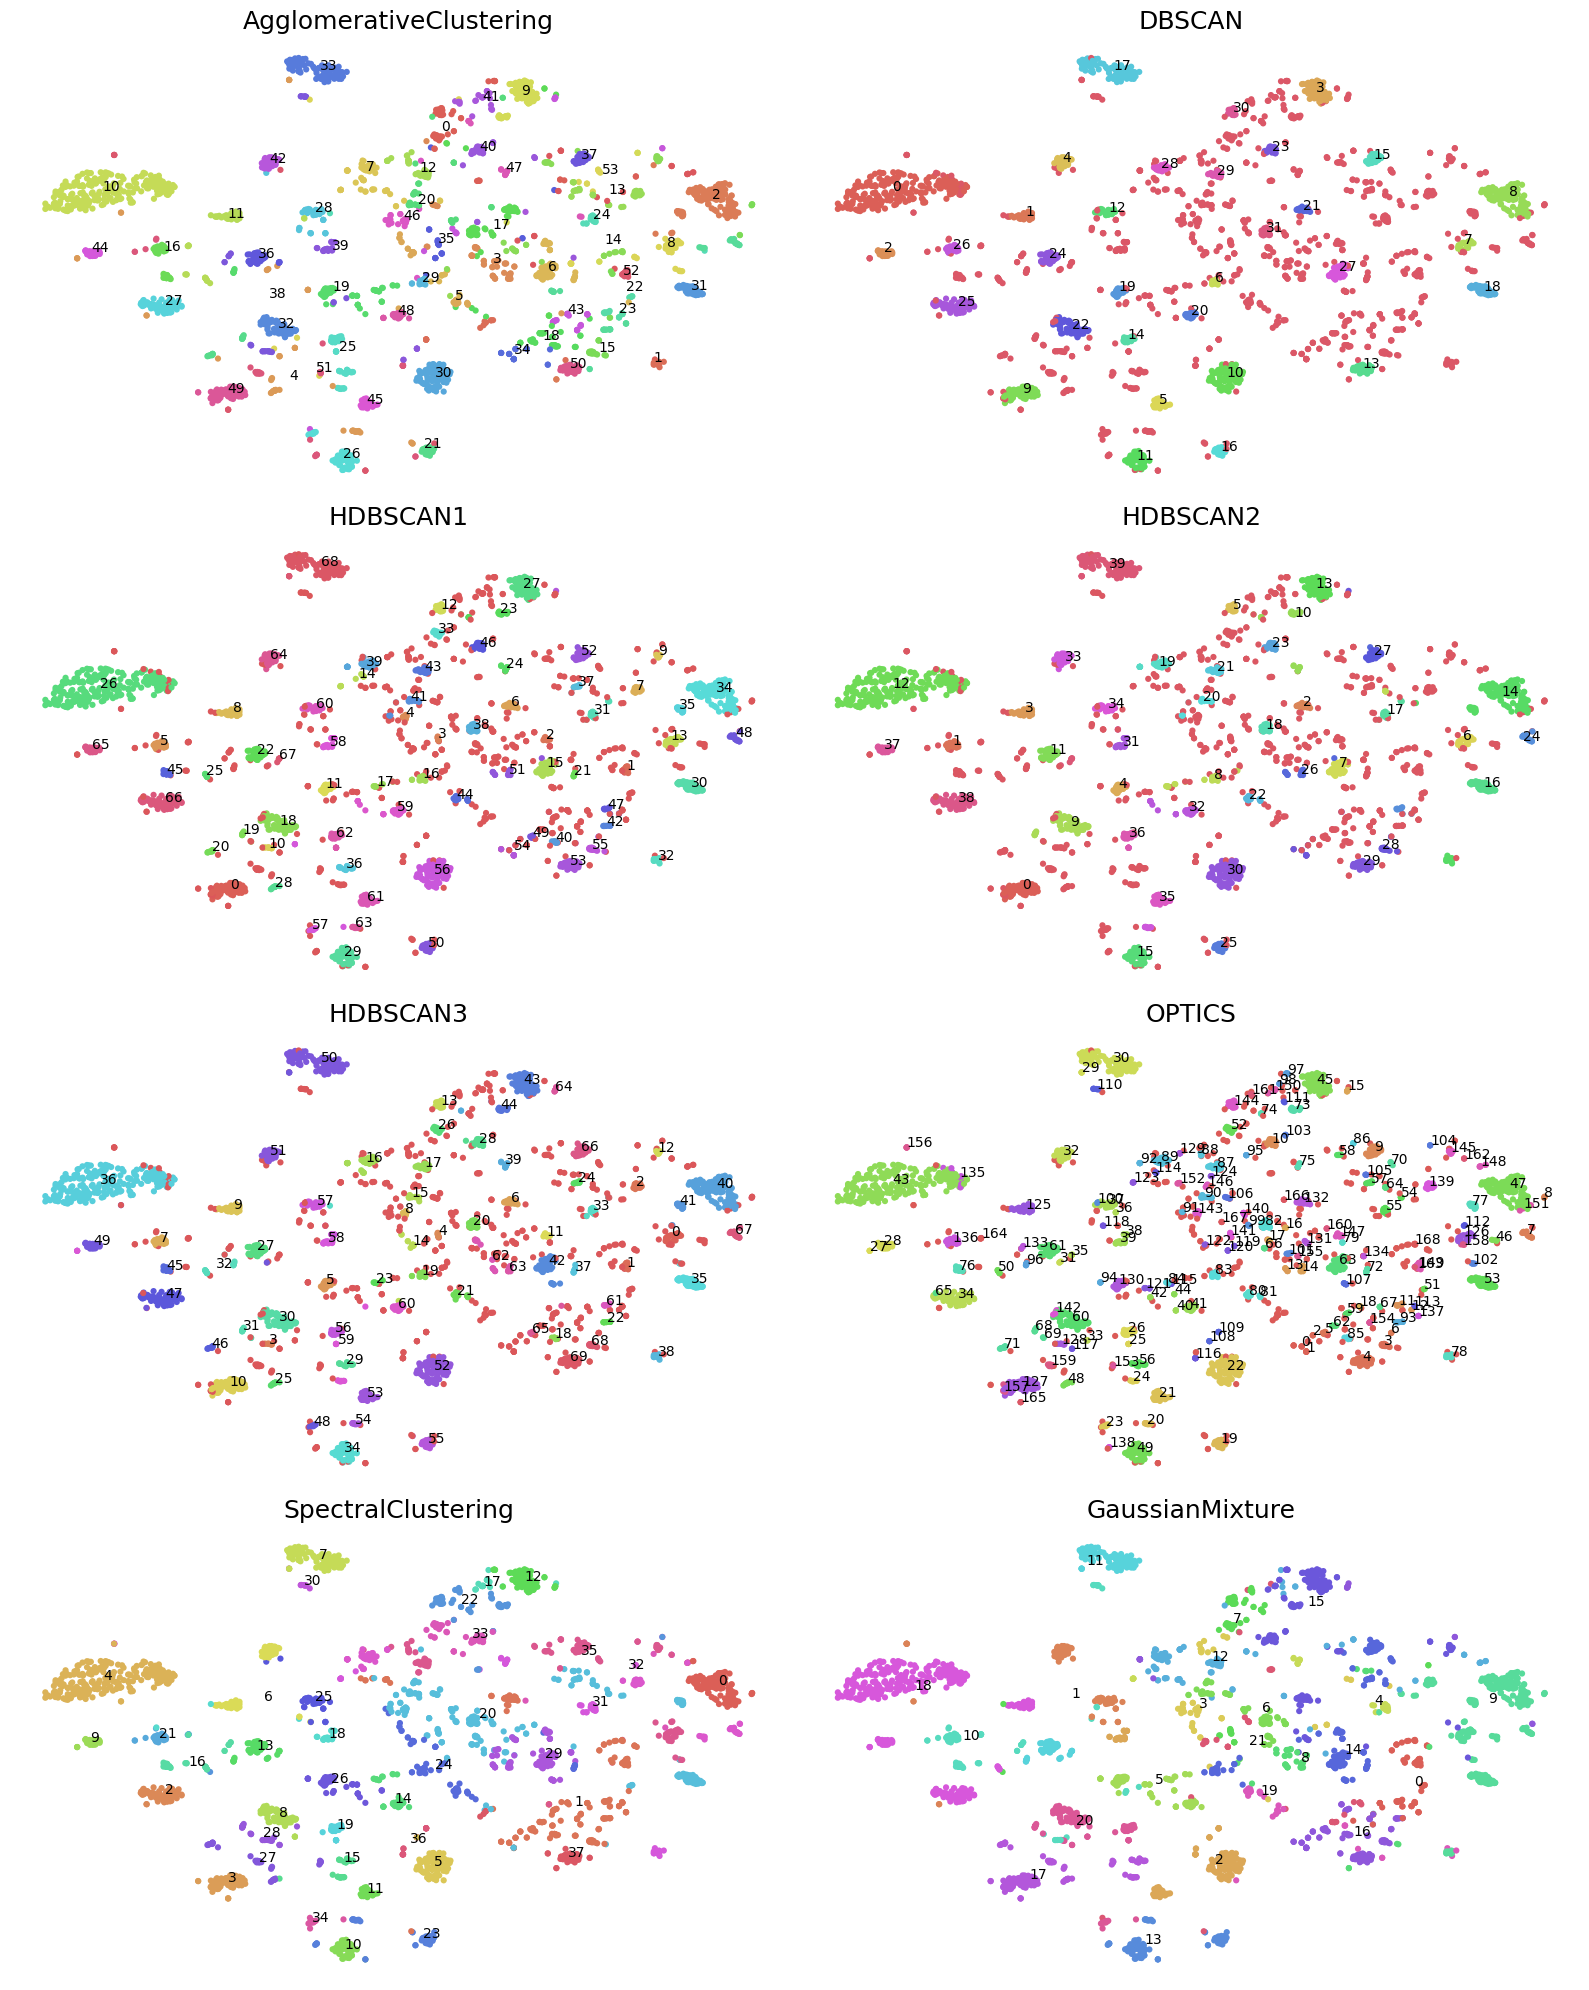

In [47]:
n = int(len(estimators)/2)
fig, axs = plt.subplots(n, 2, figsize = (16, 5*n))
axs = axs.flatten()

for i, (name, es) in enumerate(estimators):
    tSNE = TSNE(random_state=420)
    X_proj = tSNE.fit_transform(X)
    list_of_clusters = es.fit_predict(X)
    palette = np.array(sns.color_palette("hls", len(np.unique(list_of_clusters))))
    
    ax = axs[i]
    scatter = ax.scatter(X_proj[:, 0], X_proj[:, 1], lw=0, s=20, c=palette[list_of_clusters.astype(np.int64)])
    
    ax.set_aspect('equal')
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    ax.set_title(name, fontsize=18)

    txts = []
    for j in range(len(np.unique(list_of_clusters))):
        xtext, ytext = np.median(X_proj[list_of_clusters == j, :], axis=0)
        txt = ax.text(xtext, ytext, str(j), fontsize=10)
        txts.append(txt)

plt.tight_layout()
plt.show()

In [52]:
def assign_color(cluster):
    colors = {
        -1: 'white', 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'purple',
        5: 'orange', 6: 'pink', 7: 'brown', 8: 'gray', 9: 'cyan',
        10: 'magenta', 11: 'lime', 12: 'maroon', 13: 'navy', 14: 'olive',
        15: 'gold', 16: 'teal', 17: 'violet', 18: 'khaki', 19: 'coral',
        20: 'turquoise', 21: 'orchid', 22: 'salmon', 23: 'plum',
        24: 'red', 25: 'blue', 26: 'green', 27: 'yellow', 28: 'purple',
        29: 'orange', 30: 'pink', 31: 'brown', 32: 'gray', 33: 'cyan',
        34: 'magenta', 35: 'lime', 36: 'maroon', 37: 'navy', 38: 'olive',
        39: 'gold', 40: 'teal', 41: 'violet', 42: 'khaki', 43: 'coral',
        44: 'turquoise', 45: 'orchid', 46: 'salmon', 47: 'plum',
        48: 'red', 49: 'blue', 50: 'green', 51: 'yellow', 52: 'purple',
        53: 'orange', 54: 'pink', 55: 'brown', 56: 'gray', 57: 'cyan',
        58: 'magenta', 59: 'lime', 60: 'maroon', 61: 'navy', 62: 'olive',
        63: 'gold', 64: 'teal', 65: 'violet', 66: 'khaki', 67: 'coral',
        68: 'turquoise', 69: 'orchid', 70: 'salmon', 71: 'plum',
        72: 'red', 73: 'blue', 74: 'green', 75: 'yellow', 76: 'purple',
        77: 'orange', 78: 'pink', 79: 'brown', 80: 'gray', 81: 'cyan',
        82: 'magenta', 83: 'lime', 84: 'maroon', 85: 'navy', 86: 'olive',
        87: 'gold', 88: 'teal', 89: 'violet', 90: 'khaki', 91: 'coral',
        92: 'turquoise', 93: 'orchid', 94: 'salmon', 95: 'plum'
    }
    return colors.get(cluster, 'black')

In [53]:
for name, e in estimators:
    y = e.fit_predict(X)
    HDB_df = df.copy()
    HDB_df["cluster"] = y

    tmp1 = HDB_df.copy()
    tmp1['colour'] = tmp1['cluster'].apply(assign_color)

    tmp1 = tmp1.sort_values(by = "cluster")

    html1 = tmp1.style.apply(lambda row: ['background-color: ' + row['colour']] * len(row), axis=1).to_html()
    with open(f'{name}.html', 'w') as f:
        f.write(html1)